In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

In [21]:
df_T=pd.read_csv('fermentation raw data/May 26, 2023_10 58 18 AM_DTU 3-parameterValues_Temperature_Value.csv', sep=';')
df_stir=pd.read_csv('fermentation raw data/May 26, 2023_10 58 18 AM_DTU 3-parameterValues_Stirrer_Value.csv', sep=';')
df_feed1=pd.read_csv('fermentation raw data/May 26, 2023_10 58 18 AM_DTU 3-parameterValues_Feed 1_Value.csv', sep=';')
df_base=pd.read_csv('fermentation raw data/May 26, 2023_10 58 18 AM_DTU 3-parameterValues_Pump - Base_Value.csv', sep=';')
df_acid=pd.read_csv('fermentation raw data/May 26, 2023_10 58 18 AM_DTU 3-parameterValues_Pump - Acid_Value.csv', sep=';')
df_pO2=pd.read_csv('fermentation raw data/May 26, 2023_10 58 18 AM_DTU 3-parameterValues_pO₂_Value.csv', sep=';')
df_pH=pd.read_csv('fermentation raw data/May 26, 2023_10 58 18 AM_DTU 3-parameterValues_pH_Value.csv', sep=';')
df_air=pd.read_csv('fermentation raw data/May 26, 2023_10 58 18 AM_DTU 3-parameterValues_Flow - Air_Value.csv', sep=';')
df_offgas=pd.read_excel('fermentation raw data/offgas_data.xlsx')

In [22]:
# group the dataframes -- acid and base will be pre-processed differently
first_para=[df_T, df_stir, df_feed1, df_pO2, df_pH, df_air]
second_para=[df_base, df_acid]

In [23]:
start = '31-05-2023 10:14:00'
end = '02-06-2023 08:22:00'
start_time = datetime.strptime(start, '%d-%m-%Y %H:%M:%S')
end_time = datetime.strptime(end, '%d-%m-%Y %H:%M:%S')

In [24]:
# dataframes are prepared to be merged into one dataframe based on the timestamp
df_merged1=pd.DataFrame()
for df in first_para:
    df_copy=df.copy()
    # convert the timestamp into the datetime format and drop the original timestamp
    df_copy.insert(0, 'DateTime', df_copy['Date'].astype(str)+' '+df_copy['Time'].astype(str))
    df_copy.drop(['Date', 'Time'], axis=1, inplace=True)
    df_copy['DateTime']=pd.to_datetime(df_copy['DateTime'], format='%b %d, %Y %I:%M:%S %p')

    # values are converted to floats
    df_copy[df_copy.columns[1]]=df_copy[df_copy.columns[1]].str.replace(',', '.')
    df_copy[df_copy.columns[1]]=pd.to_numeric(df_copy[df_copy.columns[1]], errors='coerce')

    # reduce sample frequency to 1min which makes the merge easier
    ## mean value of each minute is taken
    df_copy.set_index('DateTime', inplace=True)
    df_resampled = df_copy.resample('1T').mean() # could be changed to sum/first/min/max...
    df_resampled = df_resampled.reset_index()
    
    # dataframe is reduced to the start and end time of the fermentation
    df_se=df_resampled[(df_resampled['DateTime'] > start_time) & (df_resampled['DateTime'] < end_time)]
    df_se = df_se.reset_index(drop=True)
    if df_merged1.empty:
        df_merged1=df_se
    else:
        df_merged1=df_merged1.merge(df_se, on='DateTime', how='inner')

In [25]:
# dataframes are prepared to be merged into one dataframe based on the timestamp
# since the feed of base/acid lasts only 5s, data will be lost if we take the first value
## instead we take the sum of the values within that minute and then later divide it by (5/60)
df_merged2=pd.DataFrame()
for df in second_para:
    df_copy=df.copy()
    # convert the timestamp into the datetime format and drop the original timestamp
    df_copy.insert(0, 'DateTime', df_copy['Date'].astype(str)+' '+df_copy['Time'].astype(str))
    df_copy.drop(['Date', 'Time'], axis=1, inplace=True)
    df_copy['DateTime']=pd.to_datetime(df_copy['DateTime'], format='%b %d, %Y %I:%M:%S %p')

    # values are converted to floats
    df_copy[df_copy.columns[1]]=df_copy[df_copy.columns[1]].str.replace(',', '.')
    df_copy[df_copy.columns[1]]=pd.to_numeric(df_copy[df_copy.columns[1]], errors='coerce')

    # reduce sample frequency to 1min which makes the merge easier
    ## mean value of each minute is taken
    df_copy.set_index('DateTime', inplace=True)
    df_resampled = df_copy.resample('1T').sum() # could be changed to sum/mean/first/min/max...
    df_resampled = df_resampled.reset_index()
    
    # dataframe is reduced to the start and end time of the fermentation
    df_se=df_resampled[(df_resampled['DateTime'] > start_time) & (df_resampled['DateTime'] < end_time)]
    df_se = df_se.reset_index(drop=True)
    if df_merged2.empty:
        df_merged2=df_se
    else:
        df_merged2=df_merged2.merge(df_se, on='DateTime', how='inner')

In [26]:
# merging the 2 dataframes
df_merged3 = df_merged1.copy()
df_merged3 = df_merged3.merge(df_merged2, on='DateTime', how='inner')

In [27]:
# offgas values are saved in another dataframe
## same preprocessing as the others

# methanol, ethanol are zero and RMS is not needed
df_offgas.drop(['offg_ethanol', 'offg_methanol', 'offg_RMS'], axis=1, inplace=True)
# reduce sample frequency to 1min which makes the merge easier
## mean value of each minute is taken
df_offgas.set_index('Timestamp', inplace=True)
df_resampled = df_offgas.resample('1T').mean() # could be changed to sum/mean/first/min/max...
df_resampled.reset_index(drop=False, inplace=True)
df_resampled.rename(columns={'Timestamp': 'DateTime'}, inplace=True)

# dataframe is reduced to the start and end time of the fermentation
df_offg=df_resampled[(df_resampled['DateTime'] > start_time) & (df_resampled['DateTime'] < end_time)]

In [28]:
# add process duration in hours as time [h]
df_merged4=df_merged3.merge(df_offg, on='DateTime', how='inner')
first_timestamp = df_merged4['DateTime'].iloc[0]  # Get the first timestamp
df_merged4['time [h]'] = (df_merged4['DateTime'] - first_timestamp) / pd.Timedelta(hours=1)
df_merged4['time [h]'] = df_merged4['time [h]'].round(2)
df_merged4.rename(columns={'Temperature Value (°C)': 'Temperature [°C]', 'Stirrer Value (rpm)': 'Stirrer [rpm]', 'pO₂ Value (pO₂)': 'DO2 [%]'}, errors='raise', inplace=True)
df_merged4.rename(columns={'offg_co2': 'Offgas CO2 [%]', 'offg_n2': 'Offgas N2 [%]', 'offg_o2': 'Offgas O2 [%]'}, errors='raise', inplace=True)
df_merged4.head(1)

,DateTime,Temperature [°C],Stirrer [rpm],Feed 1 Value (%),DO2 [%],pH Value (pH),Flow - Air Value,Pump - Base Value (%),Pump - Acid Value (%),Offgas CO2 [%],Offgas N2 [%],Offgas O2 [%],time [h]
0,2023-05-31 10:15:00,29.869167,293.464167,0.0,72.283333,7.0225,1.0,0.0,0.0,0.03907,77.497645,21.178897,0.0


In [29]:
df_biomass=pd.read_csv('fermentation raw data/biomass.csv', sep=';')
for col in df_biomass.columns:
    df_biomass[col]=df_biomass[col].str.replace(',', '.')
    df_biomass[col]=pd.to_numeric(df_biomass[col])
df_biomass.rename(columns={'duration [h]': 'time [h]', 'biomass (g/L)': 'Biomass [g/L]'}, inplace=True)
df_biomass.head(1)

,Biomass [g/L],time [h]
0,0.694,0.2


In [30]:
df = df_merged4.merge(df_biomass, on='time [h]', how='left')
df['Biomass [g/L]']=df['Biomass [g/L]'].replace('', np.nan)
df.head(1)

,DateTime,Temperature [°C],Stirrer [rpm],Feed 1 Value (%),DO2 [%],pH Value (pH),Flow - Air Value,Pump - Base Value (%),Pump - Acid Value (%),Offgas CO2 [%],Offgas N2 [%],Offgas O2 [%],time [h],Biomass [g/L]
0,2023-05-31 10:15:00,29.869167,293.464167,0.0,72.283333,7.0225,1.0,0.0,0.0,0.03907,77.497645,21.178897,0.0,NaN


In [31]:
# the peak around the 7th hour was not fed into the batch but just to accumulate the glucose in the pipe
df.loc[df.index[428:431], 'Feed 1 Value (%)'] = 0

# after 34 h the Glucose feed was most likely empty but it was still measured as feeding
df.loc[df['time [h]'] > 34, 'Feed 1 Value (%)'] = 0
df['Feed 1 Value (%)']=df['Feed 1 Value (%)']/(10*1000)
df.rename(columns={'Feed 1 Value (%)': 'Glucose feed [L/min]'}, inplace=True)

In [32]:
# one feed of base/acid lasts for max 5s. Since we have samples every minute I divided the value of the feed rate by 12 because I multiply by 5s*1/60s
df['Pump - Base Value (%)']=df['Pump - Base Value (%)']/(40*10*1000)
df['Pump - Acid Value (%)']=df['Pump - Acid Value (%)']/(40*10*1000)
df.rename(columns={'Pump - Base Value (%)': 'Pump - Base [L/min]', 'Pump - Acid Value (%)': 'Pump - Acid [L/min]', 'Flow - Air Value': 'Air feed [L/min]'}, inplace=True)

# Cumulative Base Feed
df['Cum. Base feed [L/min]']=df['Pump - Base [L/min]'].cumsum()
df['Cum. Acid feed [L/min]']=df['Pump - Acid [L/min]'].cumsum()

df['Air feed [L/min]']=df['Air feed [L/min]']/(10*1000)

In [33]:
# since the fermentation is fed-batch, the volume increases with time
df['Volume [L]']=df['Glucose feed [L/min]']+df['Pump - Base [L/min]']+df['Pump - Acid [L/min]']
df['Volume [L]']=df['Volume [L]'].cumsum().add(1)

# Feed 1 contains 350 g/L glucose so a new parameter with the feed rate in g/h is added
df['Glucose feed [g/h]']=df['Glucose feed [L/min]']*350*60

# dissolved oxygen, stirring and the temperature fluctuate a lot so exponential smooting is applied
df['DO2 [%]- smoothed']=df['DO2 [%]'].ewm(alpha=0.1).mean()
df['Stirring [rpm]- smoothed']=df['Stirrer [rpm]'].ewm(alpha=0.1).mean()
df['T [°C]- smoothed']=df['Temperature [°C]'].ewm(alpha=0.1).mean()

df.sort_index(axis=1, inplace=True)

In [34]:
# the total volume in the end of the fermentation is compared with the experimental data
df['Volume [L]'].max()

2.4677710560606094

In [35]:
# save dataframe as csv and xlsx files
df.to_csv('fermentation raw data/data_combined.csv')
df.to_excel('fermentation raw data/data_combined.xlsx')

In [36]:
df.columns

Index(['Air feed [L/min]', 'Biomass [g/L]', 'Cum. Acid feed [L/min]',
       'Cum. Base feed [L/min]', 'DO2 [%]', 'DO2 [%]- smoothed', 'DateTime',
       'Glucose feed [L/min]', 'Glucose feed [g/h]', 'Offgas CO2 [%]',
       'Offgas N2 [%]', 'Offgas O2 [%]', 'Pump - Acid [L/min]',
       'Pump - Base [L/min]', 'Stirrer [rpm]', 'Stirring [rpm]- smoothed',
       'T [°C]- smoothed', 'Temperature [°C]', 'Volume [L]', 'pH Value (pH)',
       'time [h]'],
      dtype='object')

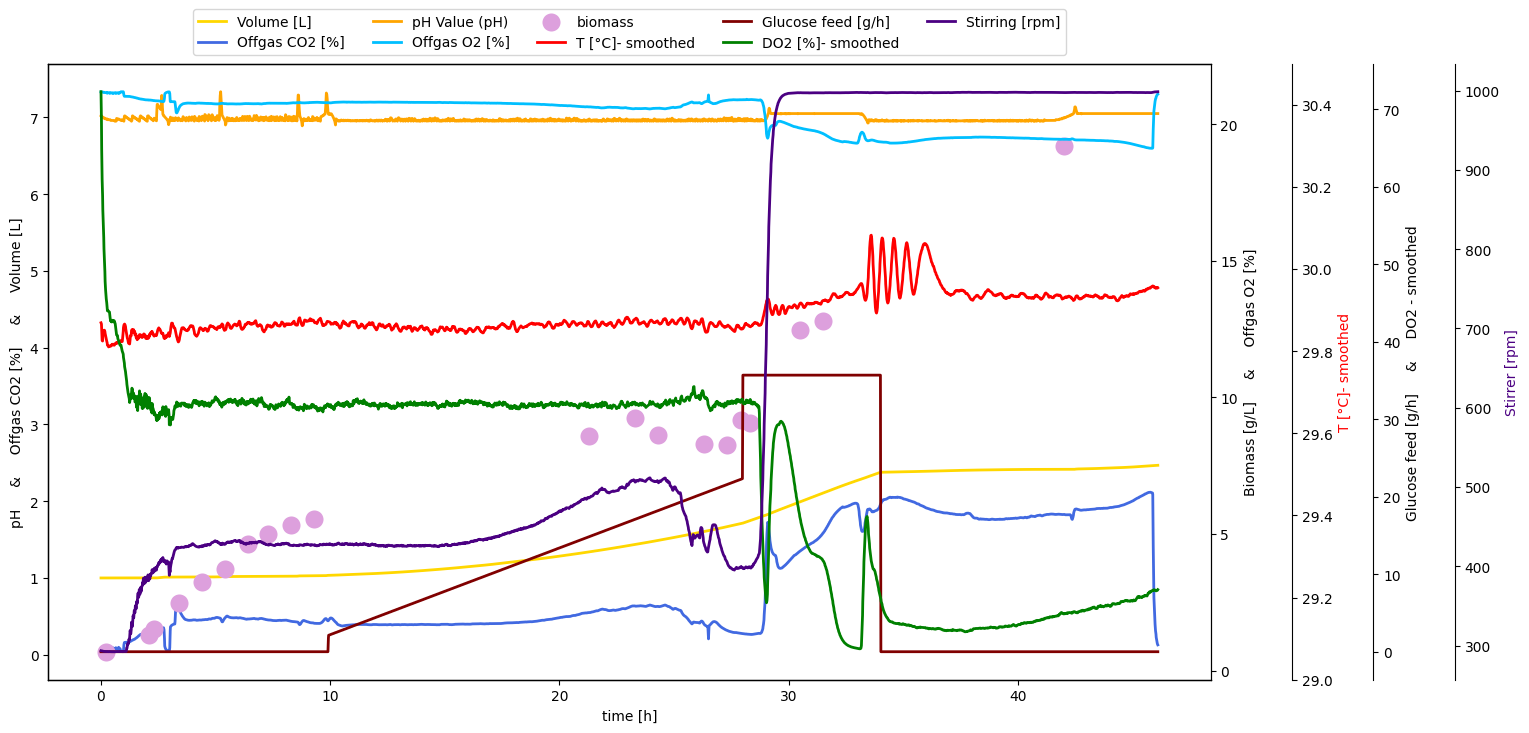

In [39]:
fig, ax = plt.subplots(1,1,figsize=(15,8))

ax_2nd=ax.twinx()
ax_3rd=ax.twinx()
ax_4th=ax.twinx()
ax_5th=ax.twinx()

ax_5th.plot(df['time [h]'], df['Stirring [rpm]- smoothed'], label='Stirring [rpm]', color='indigo', linewidth=2)
ax_4th.plot(df['time [h]'], df['Glucose feed [g/h]'], label='Glucose feed [g/h]', color='maroon', linewidth=2)
ax_4th.plot(df['time [h]'], df['DO2 [%]- smoothed'], label='DO2 [%]- smoothed', color='green', linewidth=2)
ax_3rd.plot(df['time [h]'], df['T [°C]- smoothed'], label='T [°C]- smoothed', color='red', linewidth=2)
ax_3rd.set_ylim(29,30.5)
ax_2nd.plot(df['time [h]'], df['Offgas O2 [%]'], label='Offgas O2 [%]', color='deepskyblue', linewidth=2)
ax.plot(df['time [h]'], df['Volume [L]'], label='Volume [L]', color='gold', linewidth=2)
ax.plot(df['time [h]'], df['Offgas CO2 [%]'], label='Offgas CO2 [%]', color='royalblue', linewidth=2)
ax.plot(df['time [h]'], df['pH Value (pH)'], label='pH Value (pH)', color='orange', linewidth=2)
#ax.plot(df['time [h]'], df['Air feed [mL/min]'], label='Flow - Air Value', color='aqua', linewidth=2)
ax_2nd.scatter(df['time [h]'], df['Biomass [g/L]'], linewidth=7, color='plum', label='biomass')

ax_3rd.spines.right.set_position(("axes", 1.07))
ax_4th.spines.right.set_position(("axes", 1.14))
ax_5th.spines.right.set_position(("axes", 1.21))

ax.set_xlabel('time [h]')
ax.set_ylabel('pH     &     Offgas CO2 [%]     &     Volume [L]') #     Flow - Air     &, color='orange'
ax_2nd.set_ylabel('Biomass [g/L]     &     Offgas O2 [%]') #, color='royalblue'
ax_3rd.set_ylabel('T [°C]- smoothed', color='red')
ax_4th.set_ylabel('Glucose feed [g/h]     &     DO2 - smoothed') #, color='green'
ax_5th.set_ylabel('Stirrer [rpm]', color='indigo')

# Get the handles and labels from all the axes
handles, labels = ax.get_legend_handles_labels()
handles_2nd, labels_2nd = ax_2nd.get_legend_handles_labels()
handles_3rd, labels_3rd = ax_3rd.get_legend_handles_labels()
handles_4th, labels_4th = ax_4th.get_legend_handles_labels()
handles_5th, labels_5th = ax_5th.get_legend_handles_labels()

# Combine the handles and labels from all the axes
all_handles = handles + handles_2nd + handles_3rd + handles_4th + handles_5th
all_labels = labels + labels_2nd + labels_3rd + labels_4th + labels_5th

# Create a single legend using the combined handles and labels
ax.legend(all_handles, all_labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncols=5)

plt.show()

KeyError: "None of [Index(['cum. base feed [ml/min]', 'cum. acid feed [ml/min]'], dtype='object')] are in the [columns]"

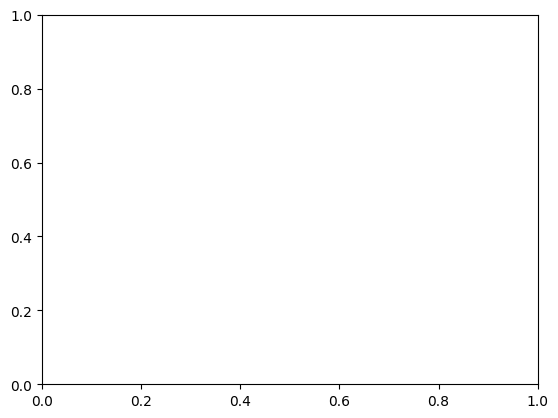

In [ ]:
fig, ax = plt.subplots()

ax.plot(df['time [h]'], df[['cum. base feed [ml/min]', 'cum. acid feed [ml/min]']], label=['Total Base mL', 'Total Acid [ml]'])

ax.set_xlabel('DateTime')
ax.set_ylabel(['Pump - Base Value (%)', 'Pump - Acid Value (%)'])
ax.legend()
plt.show()

In [ ]:
df.shape

(2767, 21)